# Imports

In [57]:
import torch  # Import the PyTorch library
import torchvision
import torch.nn as nn
import importlib
from torchvision import transforms
import numpy as np
from torchsummary import summary

import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization

import mlflow
import copy

import utils
from utils import datenum_to_datetime, FacesDataset
import models
importlib.reload(utils)
importlib.reload(models)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Define the device to use for training based on GPU availability
device = torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is not available.  Training on CPU ...


# Preprocessing

In [2]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256 originally, 224 for transformer
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 32

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")

Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
After processing:
(71828, 2)
                                            full_path  age
7   imdb_crop/02/nm0000002_rm1363385088_1924-9-16_...   80
15  imdb_crop/02/nm0000002_rm2585828096_1924-9-16_...   82
18  imdb_crop/02/nm0000002_rm2769394176_1924-9-16_...   82
19  imdb_crop/02/nm0000002_rm278040371

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


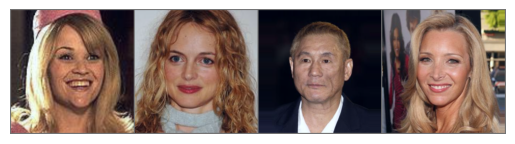

In [60]:
labels = utils.plot_images_from_loader(trainloader, num_images=4)

In [61]:
labels[:4]

tensor([0.2700, 0.3600, 0.5600, 0.4600])

In [23]:
next(dataiter).keys()

dict_keys(['image', 'age'])

# Models

In [16]:
models_descriptions = {}

## AlexNet (2 versions: train all layers and freezed)

In [17]:
net = torchvision.models.alexnet(weights='IMAGENET1K_V1') 
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
in_feat_old = net.classifier[1].in_features
net.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_feat_old, 256), ## i have to shrink a lot here  
    nn.GELU(),                 
    nn.Linear(256, 32),        
    nn.GELU(),                 
    nn.Linear(32, 1)           
)

In [19]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

models_descriptions["alexnet_freezed_till_classifier"] = copy.deepcopy(net)
summary(net);

Unfreezing layer: classifier, Parameter shape: torch.Size([256, 9216])
Unfreezing layer: classifier, Parameter shape: torch.Size([256])
Unfreezing layer: classifier, Parameter shape: torch.Size([32, 256])
Unfreezing layer: classifier, Parameter shape: torch.Size([32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1, 32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (23,296)
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       (307,392)
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       (663,936)
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       (884,992)
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      

## Mobilenet (2 versions: train all layers and freezed)

In [20]:
net = models.mobilenetv2
net.to(device);
# summary(net, (3, 256, 256));  # Input shape (channels, height, width)

In [21]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

models_descriptions["mobilenetv2_freezed_untill_classifier"] = copy.deepcopy(net)
summary(net);

Unfreezing layer: classifier, Parameter shape: torch.Size([512, 1280])
Unfreezing layer: classifier, Parameter shape: torch.Size([512])
Unfreezing layer: classifier, Parameter shape: torch.Size([32, 512])
Unfreezing layer: classifier, Parameter shape: torch.Size([32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1, 32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1])
Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            (864)
|    |    └─BatchNorm2d: 3-2                       (64)
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        (896)
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        (5,136)
|    └─InvertedResidual: 2-4               

In [22]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    for param in value.parameters():
        param.requires_grad = True
        # print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    print(f"Unfreezing all layers in {key}")  # Print unfrozen layers (classifier)
models_descriptions["mobilenetv2_completely_unfreezed"] = copy.deepcopy(net)

Unfreezing all layers in features
Unfreezing all layers in classifier


## Visual Transformer (2 versions: train all layers and freezed)

In [23]:
net = torchvision.models.vit_b_16(weights='IMAGENET1K_V1') 
print(f"original head: \n{net.heads}")
in_feat_old = net.heads.head.in_features
net.heads = nn.Sequential(
    nn.Linear(in_feat_old, 256),  
    nn.GELU(),                 
    nn.Linear(256, 32),        
    nn.GELU(),                 
    nn.Linear(32, 1)           
)
print(f"after replacing head: \n{net.heads}")
# models_descriptions["visual_transformer_completely_unfreezed"] = copy.deepcopy(net)

original head: 
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
after replacing head: 
Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=256, out_features=32, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=32, out_features=1, bias=True)
)


In [24]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "heads" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters
models_descriptions["visual_transformer_freezed"] = copy.deepcopy(net)

Unfreezing layer: heads, Parameter shape: torch.Size([256, 768])
Unfreezing layer: heads, Parameter shape: torch.Size([256])
Unfreezing layer: heads, Parameter shape: torch.Size([32, 256])
Unfreezing layer: heads, Parameter shape: torch.Size([32])
Unfreezing layer: heads, Parameter shape: torch.Size([1, 32])
Unfreezing layer: heads, Parameter shape: torch.Size([1])


# Training Function

In [25]:
def train_model(model, description, epochs = 2):   
    # Define training parameters (epochs, loss function, optimizer, and scheduler)
    criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
    scheduler = CosineAnnealingLR(optimizer,
                                  T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                                  eta_min=1e-5)  # Minimum learning rate for scheduler
    
    mlflow.start_run(run_name = description)
    mlflow.log_param("model_type", type(model).__name__)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("description", description)

    for epoch in range(epochs):
        running_loss = []
        gt_labels = []
        pr_labels = []

        model.train()

        for i, data in enumerate(trainloader):
            inputs, labels = data["image"], data["age"]
            gt_labels.append(labels.cpu().numpy())

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            pr_labels.append(outputs.squeeze().detach().cpu())

            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss.append(loss.item())
            if (i + 1) % (len(trainloader) // 10) == 0:
                gt_labels = np.concatenate(gt_labels).squeeze()
                pr_labels = np.concatenate(pr_labels).squeeze()

                s = spearmanr(gt_labels, pr_labels)[0]
                p = pearsonr(gt_labels, pr_labels)[0]
                print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                      (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))
                
                mlflow.log_metrics({'loss': np.mean(running_loss), 'PLCC': p, 'SROCC': s}, step=epoch)

                gt_labels = []
                pr_labels = []
                running_loss = []

      # Validation loop
        running_loss = []
        gt_labels = []
        pr_labels = []

        model.eval()

        for i, data in enumerate(valloader):
            inputs, labels = data["image"], data["age"]
            gt_labels.append(labels.item())

            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            pr_labels.append(outputs.squeeze().item())
            loss = criterion(outputs.squeeze(), labels.squeeze())
            running_loss.append(loss.item())

        gt_labels = np.array(gt_labels)
        pr_labels = np.array(pr_labels)
        s = spearmanr(gt_labels, pr_labels)[0]
        p = pearsonr(gt_labels, pr_labels)[0]
        print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

        # Log validation metrics
        mlflow.log_metrics({'validation_loss': np.mean(running_loss), 'validation_PLCC': p, 'validation_SROCC': s}, step=epoch)


    # Save the final model
    final_model_path = "final_model.pth"
    torch.save(model.state_dict(), final_model_path)
    mlflow.log_artifact(final_model_path)

    # Testing loop
    running_loss = []
    gt_labels = []
    pr_labels = []

    model.eval()

    for i, data in enumerate(testloader):
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        pr_labels.append(outputs.squeeze().item())
        loss = criterion(outputs.squeeze(), labels.squeeze())
        running_loss.append(loss.item())

    gt_labels = np.array(gt_labels)
    pr_labels = np.array(pr_labels)
    s = spearmanr(gt_labels, pr_labels)[0]
    p = pearsonr(gt_labels, pr_labels)[0]
    print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Log test metrics to MLflow
    mlflow.log_metrics({'test_loss': np.mean(running_loss), 'test_PLCC': p, 'test_SROCC': s})

    # Optional: Plotting
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title(f"PLCC: {p:.3f}\nSROCC: {s:.3f}")
    plt.savefig(f"{description}_test_performance.png")
    plt.show()
    plt.close()
    mlflow.end_run()
    print('Finished Training')

In [26]:
[d for d in models_descriptions.keys()]

['alexnet_freezed_till_classifier',
 'mobilenetv2_freezed_untill_classifier',
 'mobilenetv2_completely_unfreezed',
 'visual_transformer_freezed']



training of alexnet_freezed_till_classifier started, with 10 epochs


1, [67, 674] loss: 0.2049	PLCC: 0.014	SROCC: 0.210	lr: 0.001000
1, [134, 674] loss: 0.0983	PLCC: 0.412	SROCC: 0.371	lr: 0.000999
1, [201, 674] loss: 0.0920	PLCC: 0.409	SROCC: 0.375	lr: 0.000998
1, [268, 674] loss: 0.0945	PLCC: 0.441	SROCC: 0.408	lr: 0.000996
1, [335, 674] loss: 0.0897	PLCC: 0.466	SROCC: 0.431	lr: 0.000994
1, [402, 674] loss: 0.0907	PLCC: 0.486	SROCC: 0.447	lr: 0.000991
1, [469, 674] loss: 0.0929	PLCC: 0.470	SROCC: 0.425	lr: 0.000988
1, [536, 674] loss: 0.0860	PLCC: 0.521	SROCC: 0.484	lr: 0.000985
1, [603, 674] loss: 0.0866	PLCC: 0.529	SROCC: 0.466	lr: 0.000981
1, [670, 674] loss: 0.0840	PLCC: 0.546	SROCC: 0.484	lr: 0.000976
Validation loss: 0.084889	PLCC: 0.574	SROCC: 0.529
2, [67, 674] loss: 0.0840	PLCC: 0.563	SROCC: 0.508	lr: 0.000971
2, [134, 674] loss: 0.0832	PLCC: 0.562	SROCC: 0.502	lr: 0.000965
2, [201, 674] loss: 0.0838	PLCC: 0.536	SROCC: 0.486	lr: 0.000959
2, [268, 674] loss: 0.0808	PLCC: 0

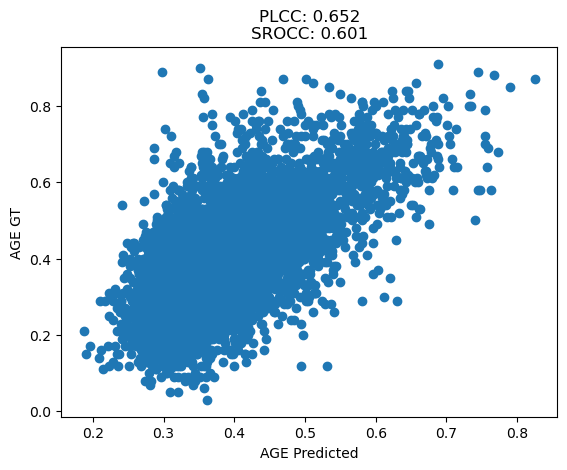

Finished Training


training of mobilenetv2_freezed_untill_classifier started, with 5 epochs


1, [67, 674] loss: 0.1211	PLCC: 0.199	SROCC: 0.273	lr: 0.000999
1, [134, 674] loss: 0.0922	PLCC: 0.481	SROCC: 0.436	lr: 0.000996
1, [201, 674] loss: 0.0871	PLCC: 0.525	SROCC: 0.502	lr: 0.000991
1, [268, 674] loss: 0.0851	PLCC: 0.557	SROCC: 0.506	lr: 0.000985
1, [335, 674] loss: 0.0832	PLCC: 0.552	SROCC: 0.512	lr: 0.000976
1, [402, 674] loss: 0.0835	PLCC: 0.540	SROCC: 0.498	lr: 0.000966
1, [469, 674] loss: 0.0839	PLCC: 0.558	SROCC: 0.516	lr: 0.000953
1, [536, 674] loss: 0.0834	PLCC: 0.584	SROCC: 0.535	lr: 0.000939
1, [603, 674] loss: 0.0790	PLCC: 0.616	SROCC: 0.580	lr: 0.000924
1, [670, 674] loss: 0.0833	PLCC: 0.579	SROCC: 0.535	lr: 0.000907
Validation loss: 0.083539	PLCC: 0.626	SROCC: 0.575
2, [67, 674] loss: 0.0838	PLCC: 0.591	SROCC: 0.533	lr: 0.000887
2, [134, 674] loss: 0.0825	PLCC: 0.604	SROCC: 0.547	lr: 0.000866
2, [201, 674] loss: 0.0787	PLCC: 0.646	SROCC: 0.610	lr: 0.000844
2, [268, 67

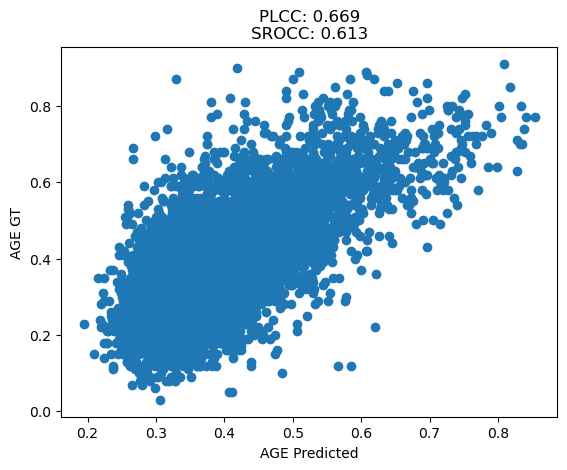

Finished Training


training of mobilenetv2_completely_unfreezed started, with 5 epochs


1, [67, 674] loss: 0.1070	PLCC: 0.314	SROCC: 0.396	lr: 0.000999
1, [134, 674] loss: 0.0820	PLCC: 0.620	SROCC: 0.567	lr: 0.000996
1, [201, 674] loss: 0.0804	PLCC: 0.642	SROCC: 0.621	lr: 0.000991
1, [268, 674] loss: 0.0737	PLCC: 0.650	SROCC: 0.625	lr: 0.000985
1, [335, 674] loss: 0.0757	PLCC: 0.664	SROCC: 0.642	lr: 0.000976
1, [402, 674] loss: 0.0730	PLCC: 0.684	SROCC: 0.661	lr: 0.000966
1, [469, 674] loss: 0.0683	PLCC: 0.733	SROCC: 0.701	lr: 0.000953
1, [536, 674] loss: 0.0698	PLCC: 0.718	SROCC: 0.690	lr: 0.000939
1, [603, 674] loss: 0.0701	PLCC: 0.718	SROCC: 0.712	lr: 0.000924
1, [670, 674] loss: 0.0676	PLCC: 0.737	SROCC: 0.724	lr: 0.000907
Validation loss: 0.067158	PLCC: 0.750	SROCC: 0.730
2, [67, 674] loss: 0.0657	PLCC: 0.758	SROCC: 0.753	lr: 0.000887
2, [134, 674] loss: 0.0658	PLCC: 0.752	SROCC: 0.724	lr: 0.000866
2, [201, 674] loss: 0.0630	PLCC: 0.767	SROCC: 0.759	lr: 0.000844
2, [268, 674] lo

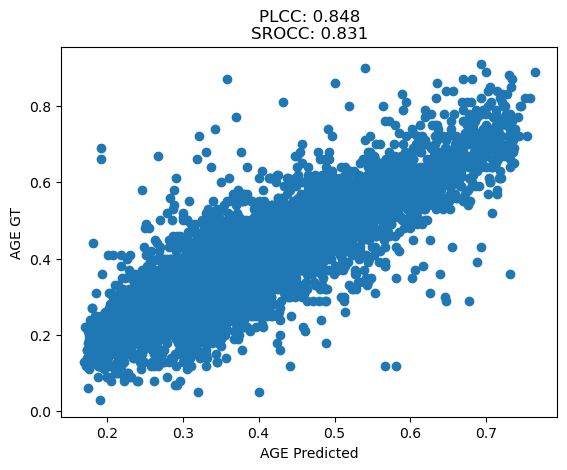

Finished Training


training of visual_transformer_freezed started, with 5 epochs


1, [67, 674] loss: 0.1009	PLCC: 0.270	SROCC: 0.313	lr: 0.000999
1, [134, 674] loss: 0.0901	PLCC: 0.475	SROCC: 0.414	lr: 0.000996
1, [201, 674] loss: 0.0873	PLCC: 0.524	SROCC: 0.465	lr: 0.000991
1, [268, 674] loss: 0.0868	PLCC: 0.520	SROCC: 0.448	lr: 0.000985
1, [335, 674] loss: 0.0841	PLCC: 0.535	SROCC: 0.492	lr: 0.000976
1, [402, 674] loss: 0.0841	PLCC: 0.598	SROCC: 0.540	lr: 0.000966
1, [469, 674] loss: 0.0827	PLCC: 0.568	SROCC: 0.533	lr: 0.000953
1, [536, 674] loss: 0.0812	PLCC: 0.610	SROCC: 0.562	lr: 0.000939
1, [603, 674] loss: 0.0818	PLCC: 0.596	SROCC: 0.549	lr: 0.000924
1, [670, 674] loss: 0.0816	PLCC: 0.613	SROCC: 0.558	lr: 0.000907
Validation loss: 0.077186	PLCC: 0.616	SROCC: 0.566
2, [67, 674] loss: 0.0741	PLCC: 0.659	SROCC: 0.602	lr: 0.000887
2, [134, 674] loss: 0.0773	PLCC: 0.641	SROCC: 0.593	lr: 0.000866
2, [201, 674] loss: 0.0774	PLCC: 0.652	SROCC: 0.597	lr: 0.000844
2, [268, 674] loss: 0.

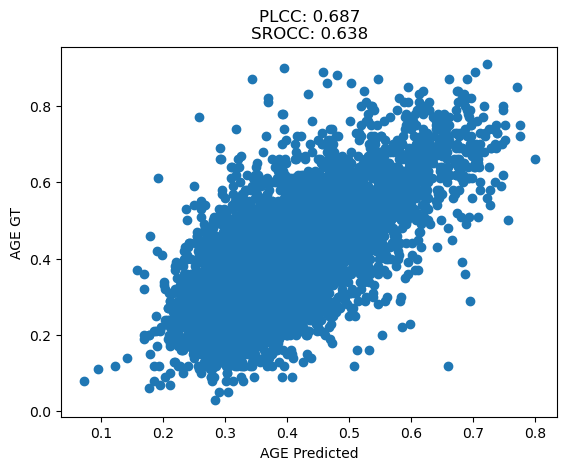

Finished Training


In [30]:
mlflow.set_experiment("Lab 6: Fine Tuning Experiment")
for d in models_descriptions:
    epochs = 5
    if d == 'alexnet_freezed_till_classifier':
        epochs = 10
    print(f"\n\ntraining of {d} started, with {epochs} epochs\n\n")
    train_model(model = models_descriptions[d], 
                description = d, 
                epochs = epochs)